# Demo 03

In [2]:
import pandas as pd

import os
print(os.listdir("A:/Downloads/retinopathy-dataset-master"))
print(os.listdir("A:/Downloads/retinopathy-dataset-master/train"))

['dataset.csv', 'newTrainLabels.csv', 'README.md', 'retinopathy_solution.csv', 'test', 'train']
['train']


In [3]:
df = pd.read_csv("A:/Downloads/retinopathy-dataset-master/newTrainLabels.csv")
df.fillna(0, inplace=True)
df.head()

,image,level,MB
0,10_left,0,0.146893
1,10_right,0,0.134647
2,13_left,0,0.179653
3,13_right,0,0.173361
4,15_left,1,0.129906


In [4]:
# Create image data generator
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.25)

# Create data generators
train_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "A:/Downloads/retinopathy-dataset-master/train/train/",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "categorical", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'training')

valid_generator = datagen.flow_from_dataframe(
    dataframe = df, 
    directory = "A:/Downloads/retinopathy-dataset-master/train/train/",
    has_ext = False,
    x_col = "image", 
    y_col = "level", 
    class_mode = "categorical", 
    target_size = (100, 100), 
    batch_size = 16,
    subset = 'validation')

Using TensorFlow backend.


Found 1547 images belonging to 5 classes.
Found 515 images belonging to 5 classes.


In [5]:
# Create a basic Sequential model with several Conv2D layers

from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras import optimizers

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

# Try a custom metrics, needs to be calculated in backend (Tensorflow)  
from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd,
             loss='categorical_crossentropy', 
              metrics = ["accuracy", "mse", rmse])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
__________

In [6]:
# Calculate how many batches are needed to go through whole train and validation set
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
N = 10 # Number of epochs

# Train and count seconds
from time import time
t1 = time()
h = model.fit_generator(generator = train_generator,
                    steps_per_epoch = 50, #STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = 15, #STEP_SIZE_VALID,
                    epochs = N,
                    verbose = 2)
t2 = time()
elapsed_time = (t2 - t1)

# Save the model
model.save('case2.h5')

# Print the total elapsed time and average time per epoch in format (hh:mm:ss)
from time import localtime, strftime
t_total = strftime('%H:%M:%S', localtime(t2 - t1))
t_per_e = strftime('%H:%M:%S', localtime((t2 - t1)/N))
print('Total elapsed time for {:d} epochs: {:s}'.format(N, t_total))
print('Average time per epoch:             {:s}'.format(t_per_e))

Epoch 1/10
 - 109s - loss: 0.8874 - acc: 0.7388 - mean_squared_error: 0.0855 - rmse: 0.2334 - val_loss: 1.1128 - val_acc: 0.5958 - val_mean_squared_error: 0.1161 - val_rmse: 0.2623
Epoch 2/10
 - 94s - loss: 0.8152 - acc: 0.7564 - mean_squared_error: 0.0791 - rmse: 0.2201 - val_loss: 1.1930 - val_acc: 0.5417 - val_mean_squared_error: 0.1203 - val_rmse: 0.3215
Epoch 3/10
 - 90s - loss: 0.8294 - acc: 0.7425 - mean_squared_error: 0.0818 - rmse: 0.2271 - val_loss: 1.2231 - val_acc: 0.5022 - val_mean_squared_error: 0.1244 - val_rmse: 0.3278
Epoch 4/10
 - 92s - loss: 0.7485 - acc: 0.7775 - mean_squared_error: 0.0721 - rmse: 0.1988 - val_loss: 1.0241 - val_acc: 0.6250 - val_mean_squared_error: 0.1025 - val_rmse: 0.2894
Epoch 5/10
 - 84s - loss: 0.7808 - acc: 0.7662 - mean_squared_error: 0.0764 - rmse: 0.2129 - val_loss: 1.0821 - val_acc: 0.6035 - val_mean_squared_error: 0.1083 - val_rmse: 0.2991
Epoch 6/10
 - 86s - loss: 0.7976 - acc: 0.7497 - mean_squared_error: 0.0793 - rmse: 0.2189 - val_lo

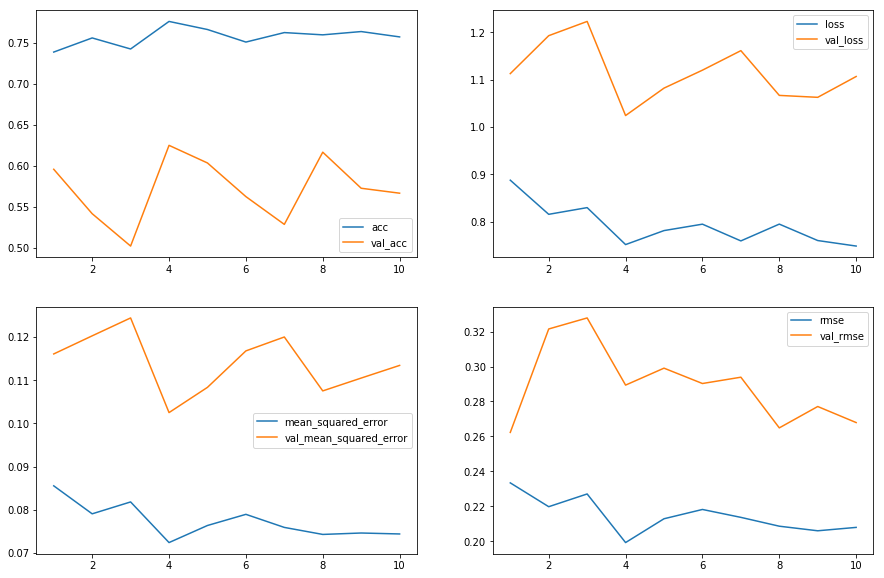

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(N) + 1.0

f, ax = plt.subplots(2, 2, figsize = (15,10))

def plotter(ax, epochs, h, variable):
    ax.plot(epochs, h.history[variable], label = variable)
    ax.plot(epochs, h.history['val_' + variable], label = 'val_'+variable)
    ax.legend()

plotter(ax[0][0], epochs, h, 'acc')
plotter(ax[0][1], epochs, h, 'loss')
plotter(ax[1][0], epochs, h, 'mean_squared_error')
plotter(ax[1][1], epochs, h, 'rmse')
plt.show()

In [10]:
# Calculate the true and predicted values
# If calculate to whole validation data set, delete/comment line 4 and remove steps from line 5
y_true = valid_generator.classes
y_true = y_true[:16*20] # Take only 20 steps, batch_size = 16
predict = model.predict_generator(valid_generator, steps = 20) # remove steps if calculate to whole dataset
y_pred = np.argmax(predict, axis = 1)

In [11]:
# Calculate and print the metrics results
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)
print('')

k = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print("Quadratic weighted Cohen's kappa = {:.4f}".format(k))
print('')

cr = classification_report(y_true, y_pred)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[141   0   0   0   0]
 [ 44   0   0   0   0]
 [101   0   0   0   0]
 [  7   0   0   0   0]
 [ 27   0   0   0   0]]

Quadratic weighted Cohen's kappa = 0.0000

Classification report:
              precision    recall  f1-score   support

           0       0.44      1.00      0.61       141
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00       101
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        27

   micro avg       0.44      0.44      0.44       320
   macro avg       0.09      0.20      0.12       320
weighted avg       0.19      0.44      0.27       320




A:\Anaconda3\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
